In [22]:
import numpy as np
import cv2
from sklearn.feature_extraction.image import extract_patches_2d as extract
from sklearn.neighbors import NearestNeighbors
import pyflann as pyflann
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
def read_images(apath, appath, bpath):
    imgA = cv2.imread(apath, cv2.IMREAD_UNCHANGED)/255.0
    imgAp = cv2.imread(appath, cv2.IMREAD_UNCHANGED)/255.0
    imgB = cv2.imread(bpath, cv2.IMREAD_UNCHANGED)/255.0

    return imgA, imgAp, imgB

In [40]:
def add_pairs(imgA, imgAp, path1, path2):
    imgA2 = cv2.imread(path1, cv2.IMREAD_UNCHANGED) / 255.0
    imgAp2 = cv2.imread(path2, cv2.IMREAD_UNCHANGED) / 255.0
    imgA2 = cv2.resize(imgA2,(imgA.shape[1],imgAp.shape[0]))
    imgAp2 = cv2.resize(imgAp2, (imgAp.shape[1],imgAp.shape[0]))
    matA = cv2.hconcat([imgA,imgA2])
    matAp = cv2.hconcat([imgAp,imgAp2])

    return matA, matAp

In [36]:
def display_2x2_images(image_paths):
    # Load images
    images = [mpimg.imread(path) for path in image_paths]
    image_labels = ['A', 'A′', 'B', 'B′']
    # Create a 2x2 grid of subplots
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    for i, image in enumerate(images, start=1):
        plt.subplot(2, 2, i)
        plt.imshow(image, cmap='gray')  # Replace 'gray' with the desired colormap
        plt.title(image_labels[i-1])
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks

    # Adjust layout and display the subplots
    plt.tight_layout()
    plt.show()

In [12]:
def remap_y(imgA,imgB):
    meanA = np.mean(imgA)
    sdA = np.std(imgA)
    meanB = np.mean(imgB)
    sdB = np.std(imgB)

    imgA_remapped = sdB/sdA*(imgA-meanA)+meanB

    return imgA_remapped

In [13]:
def rgb2yiq(image, remap=False, remap_target=None, feature='y'):
    yiq_xform = np.array([[0.299, 0.587, 0.114],
                          [0.596, -0.275, -0.321],
                         [0.212, -0.523, 0.311]])
    yiq = np.dot(image, yiq_xform.T.copy())

    if remap:
        remap_y(image, remap_target)
    if feature == 'y':
        return yiq[:,:,0]
    elif feature == 'yiq':
        return yiq

In [14]:
def yiq2rgb(image):
    rgb_xform = np.array([[1., 0.956, 0.619],
                          [1., -0.272, -0.647],
                          [1., -1.106, 1.703]])
    rgb = np.dot(image, rgb_xform.T.copy())

    return rgb

In [15]:
def get_pyramid(image, levels):
    img = image.copy()
    pyr = [img]
    for i in range(levels):
        img = cv2.pyrDown(img)
        pyr.append(img)

    return pyr

In [16]:
def get_features(img, causal=False):

    #create 5x5 neighborhood for L, pad so that feature list is correct dimensions
    patches = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_DEFAULT)
    patches = extract(patches, (5, 5))
    if causal:
        features = np.zeros((img.shape[0],img.shape[1],12))
    else:
        features = np.zeros((img.shape[0],img.shape[1],25))

    height, width = img.shape  # dimensions of the current level of the gaussian pyramid
    for i in range(height):
        for j in range(width):
                features[i, j, :] = patches[i * width + j].flatten()[0:features.shape[2]]

    return features

In [47]:
def make_analogy(lvl, Nlvl, A_L, Ap_L, B_L, Bp_L, s_L, kappa=0, method='pyflann'):
    A_f = get_features(A_L[lvl])
    Ap_f = get_features(Ap_L[lvl][:,:,0], causal=True)
    A_f = np.concatenate((A_f, Ap_f), 2)

    # initialize additional feature sets and B mats
    if lvl < Nlvl:
        Ad_f = cv2.resize(A_L[lvl+1], (A_L[lvl].shape[1],A_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Ad_f = get_features(Ad_f)
        Apd_f = cv2.resize(Ap_L[lvl + 1][:,:,0], (Ap_L[lvl].shape[1], Ap_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Apd_f = get_features(Apd_f)
        A_f = np.concatenate((A_f, Ad_f, Apd_f), 2)
        B1 = cv2.resize(B_L[lvl + 1], dsize=(B_L[lvl].shape[1], B_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Bp1 = cv2.resize(Bp_L[lvl + 1], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        B1_border = cv2.copyMakeBorder(B1, 2, 2, 2, 2, cv2.BORDER_DEFAULT)
        Bp1_border = cv2.copyMakeBorder(Bp1, 2, 2, 2, 2, cv2.BORDER_DEFAULT)

    # initialize mat by taking previous pyramid level and resize it to the same shape as the current level
    # for lvl=Nlvl you can initialize it with current Ap, B or with some randomization function. You can
    # get some really interesting results from changing the source for the first B'
    if lvl < Nlvl:
        Bp_L[lvl] = cv2.resize(Bp_L[lvl+1], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
    else:
        Bp_L[lvl] = cv2.resize(B_L[lvl], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)

    # resolve border issue by padding 2 pixels for 5x5 neighborhood
    B_border = cv2.copyMakeBorder(B_L[lvl],2,2,2,2,cv2.BORDER_DEFAULT)
    Bp_border = cv2.copyMakeBorder(Bp_L[lvl],2,2,2,2, cv2.BORDER_DEFAULT)

    # put feature list into index format M*N,numFeatures (25+12)
    A_f_2d = np.reshape(A_f, (A_f.shape[0]*A_f.shape[1], A_f.shape[2]))

    """  Begin Neighbor Search Methods  """
    if method == 'pyflann_kmeans':
        flann = pyflann.FLANN()

        print("Building FLANN kmeans index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        flann_p = flann.build_index(A_f_2d, algorithm="kmeans", branching=32, iterations=-1, checks=16)
        print("FLANN kmeans index done...")

    elif method == 'pyflann_kdtree':
        flann = pyflann.FLANN()

        print("Building FLANN kdtree index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        flann_p = flann.build_index(A_f_2d, algorithm="kdtree")
        print("FLANN kdtree index done...") 

    elif method == 'sk_nn':
        print("Building Scikit Nearest Neighbors index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        sknn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(A_f_2d)
        print("NN index done...")
    """  End Neighbor Search Methods  """

    coh_chosen = 0

    for x in range(2, B_border.shape[0]-2):
        if x%25 == 0:
            print("Rastering row", x, "of", B_border.shape[0]-4)

        for y in range(2, B_border.shape[1]-2):
            # this is where you really are in B
            bx, by = x-2, y-2

            B_patch = B_border[x-2:x+3,y-2:y+3,0].flatten()
            Bp_causal = Bp_border[x-2:x+1,y-2:y+3,0].flatten()[0:12]
            B_f = np.concatenate((B_patch, Bp_causal))

            if lvl < Nlvl:  # get same set features as A_F
                B1_patch = B1_border[x-2:x+3,y-2:y+3,0].flatten()
                Bp1_patch = Bp1_border[x-2:x+3,y-2:y+3,0].flatten()
                B_f = np.concatenate((B_f, B1_patch, Bp1_patch),0)

            if method == 'sk_nn':
                distance, neighbor = sknn.kneighbors(B_f[None, :])
                neighbor = int(neighbor[0])
            else:
                neighbor, distance = flann.nn_index(B_f, 1, checks=flann_p['checks'])
            distance = distance**2
            # get p. turn number in neighbor to coordinate in A_f
            m,n = np.unravel_index(neighbor, (A_f.shape[0], A_f.shape[1]))
            if kappa > 0:
                coh_neighbor, coh_distance = get_coherent(A_f, B_f, bx, by, s_L[lvl])
                # coh_fact is squared to get it closer to the performance as described in Hertzmann paper
                coh_fact = (1.0 + 2.0 ** (lvl - Nlvl) * kappa)**2
                if coh_distance <= distance*coh_fact:
                    m,n = coh_neighbor
                    coh_chosen += 1

            Bp_L[lvl][bx,by,0] = Ap_L[lvl][m,n,0]
            # save s
            s_L[lvl][bx, by, 0] = m
            s_L[lvl][bx, by, 1] = n

    print("coherent pixel chosen", coh_chosen, "times.")

    return Bp_L[lvl]

In [18]:
def make_analogy_color(lvl, Nlvl, A_L, Ap_L, B_L, Bp_L, s_L, kappa=0, method='pyflann'):
    A_f = get_features(rgb2yiq(A_L[lvl], remap=True, remap_target=B_L[lvl]))
    Ap_f = get_features(rgb2yiq(Ap_L[lvl], remap=True, remap_target=B_L[lvl]), causal=True)
    A_f = np.concatenate((A_f, Ap_f), 2)

    # initialize additional feature sets and B mats
    if lvl < Nlvl:
        Ad_f = cv2.resize(A_L[lvl+1], (A_L[lvl].shape[1],A_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Ad_f = get_features(rgb2yiq(Ad_f, remap=True, remap_target=B_L[lvl+1]))
        Apd_f = cv2.resize(Ap_L[lvl + 1], (Ap_L[lvl].shape[1], Ap_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Apd_f = get_features(rgb2yiq(Apd_f, remap=True, remap_target=B_L[lvl+1]))
        A_f = np.concatenate((A_f, Ad_f, Apd_f), 2)
        B1 = cv2.resize(B_L[lvl + 1], dsize=(B_L[lvl].shape[1], B_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        Bp1 = cv2.resize(Bp_L[lvl + 1], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
        B1_border = cv2.copyMakeBorder(B1, 2, 2, 2, 2, cv2.BORDER_DEFAULT)
        Bp1_border = cv2.copyMakeBorder(Bp1, 2, 2, 2, 2, cv2.BORDER_DEFAULT)

    # initialize mat by taking previous pyramid level and resize it to the same shape as the current level
    # for lvl=Nlvl you can initialize it with current Ap or with some randomization function
    if lvl < Nlvl:
        Bp_L[lvl] = cv2.resize(Bp_L[lvl+1], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)
    else:
        Bp_L[lvl] = cv2.resize(B_L[lvl], dsize=(Bp_L[lvl].shape[1], Bp_L[lvl].shape[0]), interpolation=cv2.INTER_CUBIC)

    # resolve border issue by padding 2 pixels for 5x5 neighborhood
    B_border = cv2.copyMakeBorder(B_L[lvl],2,2,2,2,cv2.BORDER_DEFAULT)
    Bp_border = cv2.copyMakeBorder(Bp_L[lvl],2,2,2,2, cv2.BORDER_DEFAULT)

    # put feature list into index format M*N,numFeatures (25+12)
    A_f_2d = np.reshape(A_f, (A_f.shape[0]*A_f.shape[1], A_f.shape[2]))

    """  Begin Neighbor Search Methods  """
    if method == 'pyflann_kmeans':
        flann = pyflann.FLANN()

        print("Building FLANN kmeans index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        flann_p = flann.build_index(A_f_2d, algorithm="kmeans", branching=32, iterations=-1, checks=16)
        print("FLANN kmeans index done...")

    elif method == 'pyflann_kdtree':
        flann = pyflann.FLANN()

        print("Building FLANN kdtree index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        flann_p = flann.build_index(A_f_2d, algorithm="kdtree")
        print("FLANN kdtree index done...")

    elif method == 'sk_nn':
        print("Building Scikit Nearest Neighbors index for size:", A_f.size, "for A size", Ap_L[lvl].size)
        sknn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(A_f_2d)
        print("NN index done...")
    """  End Neighbor Search Methods  """

    coh_chosen = 0

    for x in range(2, B_border.shape[0]-2):
        #Bp_int = np.uint8(Bp_L[lvl][:,:,0].copy()*255)
        #cv2.imshow("bp", Bp_int)
        #cv2.waitKey(1)
        if x%25 == 0:
            print("Rastering row", x, "of", B_border.shape[0]-4)

        for y in range(2, B_border.shape[1]-2):
            # this is where you really are in B
            bx = x-2
            by = y-2

            B_patch = rgb2yiq(B_border[x-2:x+3,y-2:y+3]).flatten()
            Bp_causal = rgb2yiq(Bp_border[x-2:x+1,y-2:y+3]).flatten()[0:12]
            B_f = np.concatenate((B_patch, Bp_causal))

            if lvl < Nlvl:  # get same set features as A_F
                B1_patch = rgb2yiq(B1_border[x-2:x+3,y-2:y+3]).flatten()
                Bp1_patch = rgb2yiq(Bp1_border[x-2:x+3,y-2:y+3]).flatten()
                B_f = np.concatenate((B_f, B1_patch, Bp1_patch),0)

            if method == 'sk_nn':
                distance, neighbor = sknn.kneighbors(B_f[None, :])
                neighbor = int(neighbor[0])
            else:
                neighbor, distance = flann.nn_index(B_f, 1, checks=flann_p['checks'])
            distance = distance**2
            # get p
            # turn number in neighbor to coordinate in A_f
            m,n = np.unravel_index(neighbor, (A_f.shape[0], A_f.shape[1]))
            if kappa > 0:  # kappa > 0
                coh_neighbor, coh_distance = get_coherent(A_f, B_f, bx, by, s_L[lvl])
                # coh_fact is squared to get it closer to the performance as described in Hertzmann paper
                coh_fact = (1.0 + 2.0 ** (lvl - Nlvl) * kappa)**2
                if coh_distance <= distance*coh_fact:
                    m,n = coh_neighbor
                    coh_chosen += 1


            Bp_L[lvl][bx,by,:] = Ap_L[lvl][m,n,:]  # move value into Bprime

            # save s
            s_L[lvl][bx, by, 0] = m
            s_L[lvl][bx, by, 1] = n


    print("Coherent pixel chosen", coh_chosen, "/", Bp_L[lvl].size, "times.")

    return Bp_L[lvl]


In [19]:
def get_coherent(A_f,B_f,x,y,s):  # tuned for 5x5 patches only
    min_distance = np.inf
    cohxy = [-1, -1]
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            if i == 0 and j == 0:  # only do causal portion
                break
            if x+i >= s.shape[0] or y+j >= s.shape[1]:
                continue
            sx,sy = int(s[x+i,y+j,0]),int(s[x+i,y+j,1])
            if sx == -1 or sy == -1:
                continue
            rx, ry = sx-i, sy-j
            if rx < 0 or rx >= A_f.shape[0] or ry < 0 or ry >= A_f.shape[1]:
                continue
            rstar = np.sum((A_f[rx,ry,:]-B_f)**2)
            if rstar < min_distance:
                min_distance = rstar
                cohxy = rx, ry

    return cohxy, min_distance

In [24]:
def image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='color',
                        image_paths=("src/A.jpg", "src/Ap.jpg", "src/B.jpg")):
    # Read in images
    imgA, imgAp, imgB = read_images(*image_paths)
    # Initialize pyramids
    if type == 'luminance':
        A_L = get_pyramid(rgb2yiq(imgA), pyr_levels)
        B_L = get_pyramid(rgb2yiq(imgB, feature='yiq'), pyr_levels)
        Ap_L = get_pyramid(rgb2yiq(imgAp, feature='yiq'), pyr_levels)
    elif type == 'color':
        A_L = get_pyramid(imgA, pyr_levels)
        B_L = get_pyramid(imgB, pyr_levels)
        Ap_L = get_pyramid(imgAp, pyr_levels)
        
    Bp_L = []
    s = []
    for i in range(len(B_L)):
        Bp_L.append(np.zeros(B_L[i].shape))
        s.append(np.zeros((B_L[i].shape[0], B_L[i].shape[1], 2)) - 1)

    # Process pyramid from coarsest to finest
    for lvl in range(pyr_levels, -1, -1):
        print("Starting Level: ", lvl, "of ", pyr_levels)

        if type == 'luminance':
            Bp_L[lvl] = make_analogy(lvl, pyr_levels, A_L, Ap_L, B_L, Bp_L, s, kappa, search_method)
            Bp_int = np.uint8(Bp_L[lvl][:, :, 0].copy() * 255)
            cv2.imshow("bp", Bp_int)
            cv2.waitKey(1)
            imgBp = yiq2rgb(Bp_L[lvl])

        elif type == 'color':
            Bp_L[lvl] = make_analogy_color(lvl, pyr_levels, A_L, Ap_L, B_L, Bp_L, s, kappa, search_method)
            Bp_int = (Bp_L[lvl] * 255).astype('uint8')
            cv2.imshow("bp", Bp_int)
            cv2.waitKey(1)
            imgBp = Bp_L[lvl]

        imgBp = imgBp * 255.0
        imgBp[imgBp > 255] = 255
        imgBp[imgBp < 0] = 0

        write_name = 'out/Bp_PyrLvl-'+str(lvl)+'.jpg'
        cv2.imwrite(write_name, imgBp)
    cv2.imwrite("output/output_image.jpg", imgBp)


Starting Level:  5 of  5
Building FLANN kdtree index for size: 2960 for A size 240
FLANN kdtree index done...
Coherent pixel chosen 0 / 240 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 26100 for A size 900
FLANN kdtree index done...
Coherent pixel chosen 0 / 900 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 104400 for A size 3600
FLANN kdtree index done...
Rastering row 25 of 30
Coherent pixel chosen 0 / 3600 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 417600 for A size 14400
FLANN kdtree index done...
Rastering row 25 of 60
Rastering row 50 of 60
Coherent pixel chosen 0 / 14400 times.
Starting Level:  1 of  5
Building FLANN kdtree index for size: 1670400 for A size 57600
FLANN kdtree index done...
Rastering row 25 of 120
Rastering row 50 of 120
Rastering row 75 of 120
Rastering row 100 of 120
Coherent pixel chosen 0 / 57600 times.
Starting Level:  0 of  5
Building FLANN kdtree index for size: 6681600 for A size

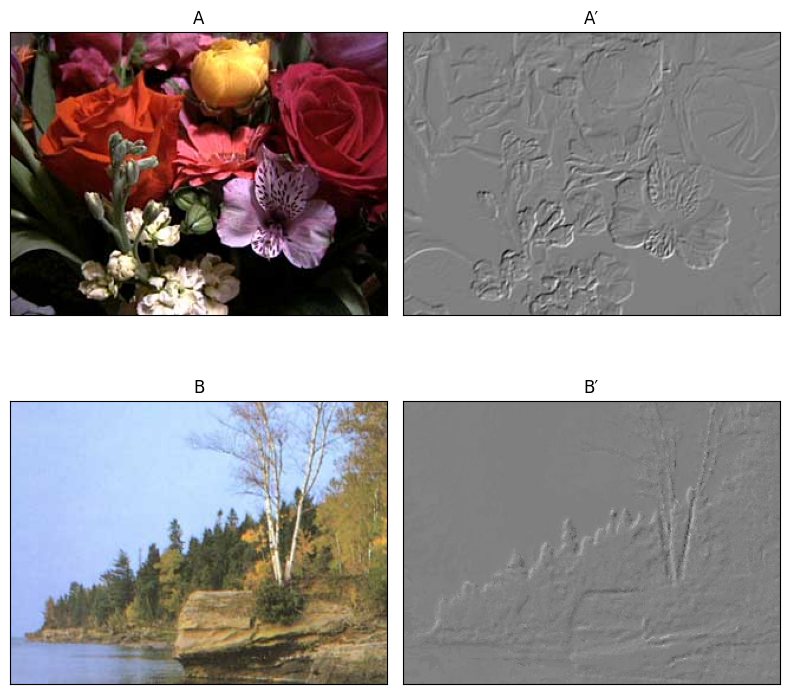

In [39]:
# Emboss filter Exemple
image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='color',
                        image_paths=("src0/A.jpg", "src0/Ap.jpg", "src0/B.jpg"))
image_paths = ['src0/A.jpg', 'src0/Ap.jpg', 'src0/B.jpg', 'output/output_image.jpg']
display_2x2_images(image_paths)

# Super-resolution: 
## Inferring a high-resolution image from a low-resolutinon source.
### Notes:
- The algorithm to include multiple training pairs.

In [42]:
remap_A = 1
pyr_levels = 5
kappa = 0
search_method = 'pyflann_kdtree'
imgA, imgAp, imgB = read_images("src1/A.jpg", "src1/Ap.jpg", "src1/B.jpg")
imgA, imgAp = add_pairs(imgA, imgAp, "src1/A2.jpg", "src1/Ap2.jpg")
imgA, imgAp = add_pairs(imgA, imgAp, "src1/A3.jpg", "src1/Ap3.jpg")
# initialize pyramids (denoted by _L)
if type == 'luminance':
    A_L = get_pyramid(rgb2yiq(imgA), pyr_levels)
    B_L = get_pyramid(rgb2yiq(imgB, feature='yiq'), pyr_levels)
    Ap_L = get_pyramid(rgb2yiq(imgAp, feature='yiq'), pyr_levels)
elif type == 'color':
    A_L = get_pyramid(imgA, pyr_levels)
    B_L = get_pyramid(imgB, pyr_levels)
    Ap_L = get_pyramid(imgAp, pyr_levels)

Bp_L = []
s = []
for i in range(len(B_L)):
    Bp_L.append(np.zeros(B_L[i].shape))
    s.append(np.zeros((B_L[i].shape[0],B_L[i].shape[1],2))-1)

# process pyramid from coursest to finest
for lvl in range(pyr_levels, -1, -1):
    print("Starting Level: ", lvl, "of ", pyr_levels)
    Bp_L[lvl] = make_analogy_color(lvl, pyr_levels, A_L, Ap_L, B_L, Bp_L, s, kappa, search_method)
    Bp_int = np.uint8(Bp_L[lvl].copy() * 255)
    cv2.imshow("bp", Bp_int)
    cv2.waitKey(1)
    imgBp = Bp_L[lvl]

    imgBp = imgBp * 255.0
    imgBp[imgBp > 255] = 255
    imgBp[imgBp < 0] = 0

    write_name = 'out/Bp_PyrLvl-'+str(lvl)+'.jpg'
    cv2.imwrite(write_name, imgBp)
cv2.imwrite("output/output_image.jpg", imgBp)

Starting Level:  5 of  5
Building FLANN kdtree index for size: 9176 for A size 744
FLANN kdtree index done...
Rastering row 25 of 27
Coherent pixel chosen 0 / 1296 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 79605 for A size 2745
FLANN kdtree index done...
Rastering row 25 of 54
Rastering row 50 of 54
Coherent pixel chosen 0 / 5184 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 318420 for A size 10980
FLANN kdtree index done...
Rastering row 25 of 108
Rastering row 50 of 108
Rastering row 75 of 108
Rastering row 100 of 108
Coherent pixel chosen 0 / 20736 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 1273680 for A size 43920
FLANN kdtree index done...
Rastering row 25 of 215
Rastering row 50 of 215
Rastering row 75 of 215
Rastering row 100 of 215
Rastering row 125 of 215
Rastering row 150 of 215
Rastering row 175 of 215
Rastering row 200 of 215
Coherent pixel chosen 0 / 81915 times.
Starting Level:  1 of  5
Buildin

True

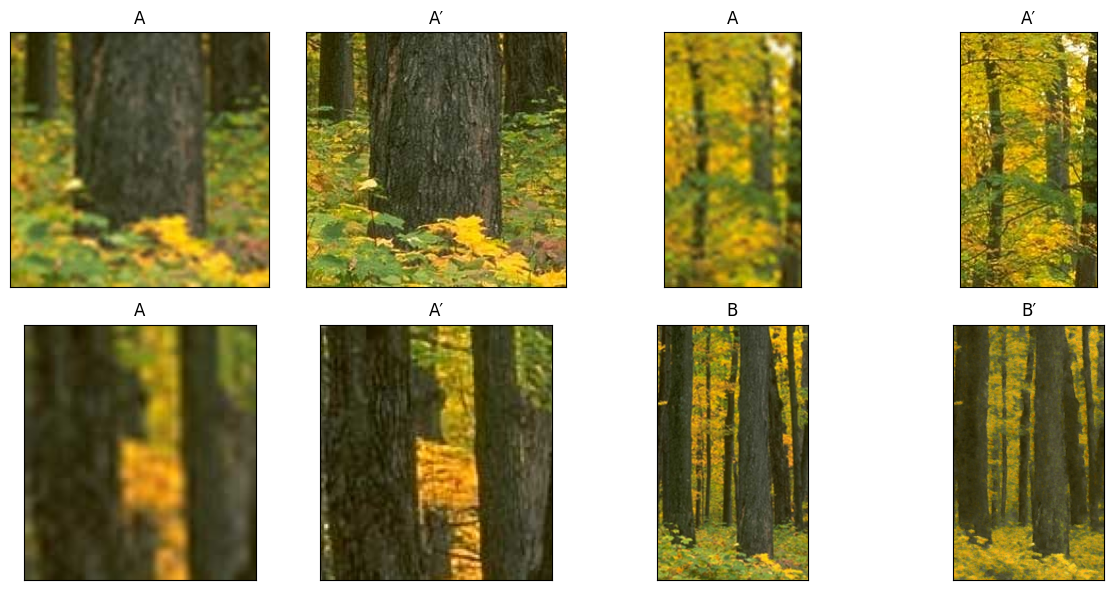

In [43]:
images = [mpimg.imread(path) for path in ["src1/A.jpg", "src1/Ap.jpg","src1/A2.jpg", "src1/Ap2.jpg","src1/A3.jpg", "src1/Ap3.jpg", "src1/B.jpg",'output/output_image.jpg']]
image_labels = ['A', 'A′','A', 'A′','A', 'A′', 'B', 'B′']

plt.figure(figsize=(12, 6))

for i, image in enumerate(images, start=1):
    plt.subplot(2, 4, i)
    plt.imshow(image, cmap='gray')  # Replace 'gray' with the desired colormap
    plt.title(image_labels[i-1])
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

# Artistic filters: 
## Given a source photograph and a painting or drawing of it, the algorithm automatically learn a filter that transforms another photograph into some approximation of that painting or drawing style
### Notes:
- The result with type= color is not good
- The result are so much better with type=luminance

Starting Level:  5 of  5
Building FLANN kdtree index for size: 11100 for A size 900
FLANN kdtree index done...
coherent pixel chosen 0 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 104400 for A size 3600
FLANN kdtree index done...
Rastering row 25 of 32
coherent pixel chosen 0 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 417600 for A size 14400
FLANN kdtree index done...
Rastering row 25 of 63
Rastering row 50 of 63
coherent pixel chosen 0 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 1670400 for A size 57600
FLANN kdtree index done...
Rastering row 25 of 125
Rastering row 50 of 125
Rastering row 75 of 125
Rastering row 100 of 125
Rastering row 125 of 125
coherent pixel chosen 0 times.
Starting Level:  1 of  5
Building FLANN kdtree index for size: 6681600 for A size 230400
FLANN kdtree index done...
Rastering row 25 of 250
Rastering row 50 of 250
Rastering row 75 of 250
Rastering row 100 of 250
Rastering row 125 o

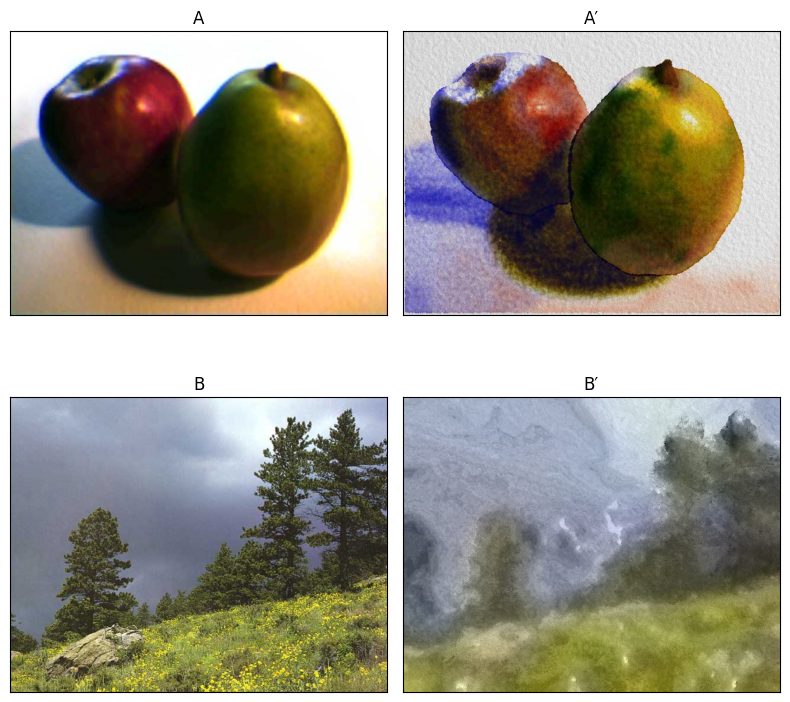

In [49]:
image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='luminance',
                        image_paths=("src3/A.jpg", "src3/Ap.jpg", "src3/B.jpg"))
image_paths = ['src3/A.jpg', 'src3/Ap.jpg', 'src3/B.jpg', 'output/output_image.jpg']
display_2x2_images(image_paths)

# Texture-by-numbers: 
### Texture-by-numbers allows new imagery to be synthesized by applying the statistics of a labeled example image to a new labeling image B.

Starting Level:  5 of  5
Building FLANN kdtree index for size: 5550 for A size 450
FLANN kdtree index done...
Coherent pixel chosen 0 / 450 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 50460 for A size 1740
FLANN kdtree index done...
Rastering row 25 of 29
Coherent pixel chosen 0 / 1740 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 201840 for A size 6960
FLANN kdtree index done...
Rastering row 25 of 58
Rastering row 50 of 58
Coherent pixel chosen 0 / 6960 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 807360 for A size 27840
FLANN kdtree index done...
Rastering row 25 of 116
Rastering row 50 of 116
Rastering row 75 of 116
Rastering row 100 of 116
Coherent pixel chosen 0 / 27840 times.
Starting Level:  1 of  5
Building FLANN kdtree index for size: 3215520 for A size 110880
FLANN kdtree index done...
Rastering row 25 of 231
Rastering row 50 of 231
Rastering row 75 of 231
Rastering row 100 of 231
Rastering row 125 of

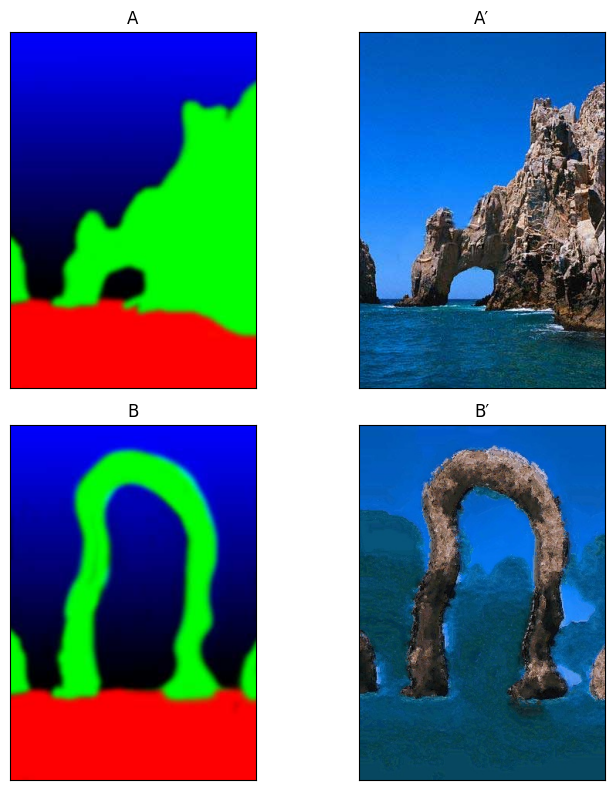

In [37]:
image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='color',
                        image_paths=("src/A.jpg", "src/Ap.jpg", "src/B.jpg"))
image_paths = ['src/A.jpg', 'src/Ap.jpg', 'src/B.jpg', 'output/output_image.jpg']
display_2x2_images(image_paths)

Starting Level:  5 of  5
Building FLANN kdtree index for size: 8325 for A size 675
FLANN kdtree index done...
Coherent pixel chosen 0 / 675 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 78300 for A size 2700
FLANN kdtree index done...
Rastering row 25 of 30
Coherent pixel chosen 0 / 2700 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 313200 for A size 10800
FLANN kdtree index done...
Rastering row 25 of 60
Rastering row 50 of 60
Coherent pixel chosen 0 / 10800 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 1252800 for A size 43200
FLANN kdtree index done...
Rastering row 25 of 120
Rastering row 50 of 120
Rastering row 75 of 120
Rastering row 100 of 120
Coherent pixel chosen 0 / 43200 times.
Starting Level:  1 of  5
Building FLANN kdtree index for size: 5011200 for A size 172800
FLANN kdtree index done...
Rastering row 25 of 240
Rastering row 50 of 240
Rastering row 75 of 240
Rastering row 100 of 240
Rastering row 125

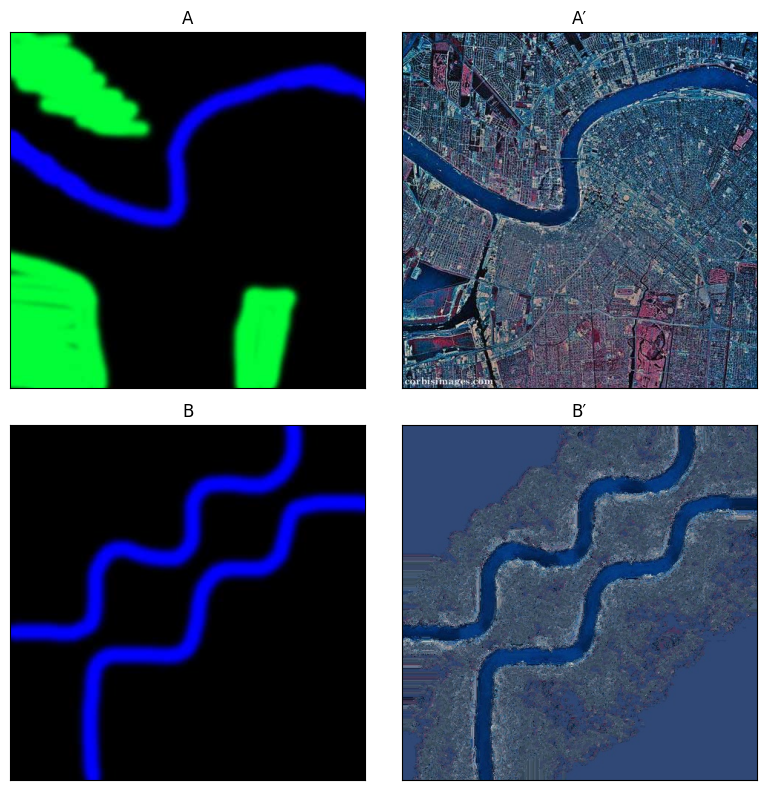

In [46]:
image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='color',
                        image_paths=("src4/A.jpg", "src4/Ap.jpg", "src4/B.jpg"))
image_paths = ['src4/A.jpg', 'src4/Ap.jpg', 'src4/B.jpg', 'output/output_image.jpg']
display_2x2_images(image_paths)

# Image Colorization: 
### Notes:


Starting Level:  5 of  5
Building FLANN kdtree index for size: 1998 for A size 162
FLANN kdtree index done...
Coherent pixel chosen 0 / 162 times.
Starting Level:  4 of  5
Building FLANN kdtree index for size: 16269 for A size 561
FLANN kdtree index done...
Coherent pixel chosen 0 / 561 times.
Starting Level:  3 of  5
Building FLANN kdtree index for size: 60291 for A size 2079
FLANN kdtree index done...
Coherent pixel chosen 0 / 2079 times.
Starting Level:  2 of  5
Building FLANN kdtree index for size: 237510 for A size 8190
FLANN kdtree index done...
Rastering row 25 of 42
Coherent pixel chosen 0 / 8190 times.
Starting Level:  1 of  5
Building FLANN kdtree index for size: 942732 for A size 32508
FLANN kdtree index done...
Rastering row 25 of 84
Rastering row 50 of 84
Rastering row 75 of 84
Coherent pixel chosen 0 / 32508 times.
Starting Level:  0 of  5
Building FLANN kdtree index for size: 3770928 for A size 130032
FLANN kdtree index done...
Rastering row 25 of 168
Rastering row 50 of

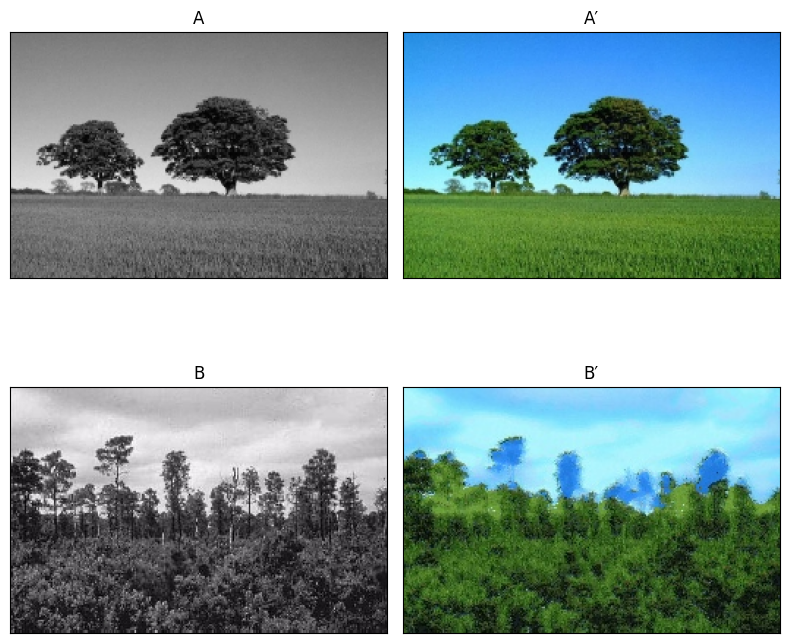

In [50]:
image_synthesis_pipeline(remap_A=1, pyr_levels=5, kappa=0, search_method='pyflann_kdtree', type='color',
                        image_paths=("src5/A.jpg", "src5/Ap.jpg", "src5/B.jpg"))
image_paths = ['src5/A.jpg', 'src5/Ap.jpg', 'src5/B.jpg', 'output/output_image.jpg']
display_2x2_images(image_paths)